In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals
import MDAnalysis.analysis as analysis
import MDAnalysis.analysis.rms
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
# from scipy.signal import find_peaks, peak_prominences
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.rcParams["font.family"] = "Times"
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
import os
import sys
import glob
import pathlib
from scipy import spatial

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
import pickle

https://docs.mdanalysis.org/stable/documentation_pages/selections.html

http://nglviewer.org/nglview/latest/

https://userguide.mdanalysis.org/1.0.0/examples/analysis/structure/dihedrals.html

In [22]:
pwd

'/Volumes/XinyanHD1/COVID19_data/TMD/head_protomer/scripts'

In [7]:
sys_up = '../sys_up'
sys_down = '../sys_down'

gly_d2u = '../1-head_pro_gly_tmd_d2u'
gly_u2d = '../1-head_pro_gly_tmd_u2d'
gly2_d2u = '../2-head_pro_gly_tmd_d2u'
gly2_u2d = '../2-head_pro_gly_tmd_u2d'
gly3_d2u = '../3-head_pro_gly_tmd_d2u'
gly3_u2d = '../3-head_pro_gly_tmd_u2d'
gly4_d2u = '../4-head_pro_gly_tmd_d2u'
gly4_u2d = '../4-head_pro_gly_tmd_u2d'
gly5_d2u = '../5-head_pro_gly_tmd_d2u'
gly5_u2d = '../5-head_pro_gly_tmd_u2d'
gly6_d2u = '../6-head_pro_gly_tmd_d2u'
gly6_u2d = '../6-head_pro_gly_tmd_u2d'


equil_gly_down = '../0-tmdminequil_gly_down'
equil_gly_up = '../0-tmdminequil_gly_up'
equil_nogly_down = '../0-tmdminequil_nogly_down'
equil_nogly_up = '../0-tmdminequil_nogly_up'

From Jenny MDAna_tutorial_RMSA_20Nov23

In [12]:
def sel2phipsi(u, degree2radian=True):
    """MDAna selection u to phi and psi lists by segid
    NB: segid is sometimes chain in VMD"""
    segname_list = u.segments.segids.tolist()
    psi_list = []
    phi_list = []
    for seg in segname_list:
        # Chain information
        chain = u.select_atoms(f"protein and segid {seg}")
        # Phi and psi
        phi_sel, psi_sel, ind_phi, ind_psi = get_phipsi_sel(chain)
        phi_ang = get_dihe_ang(phi_sel, degree2radian)
        psi_ang = get_dihe_ang(psi_sel, degree2radian)
        # Append
        phi_list.append(phi_ang)
        psi_list.append(psi_ang)
    return phi_list, psi_list

def get_phipsi_sel(protein):
    # NB: to get a selection, e.g. protein = u.select_atoms("protein")
    phi_sel = [res.phi_selection() for res in protein.residues[:]]
    psi_sel = [res.psi_selection() for res in protein.residues[:]]
    # deal with None (edges)
    ind_phi, phi_sel = get_ind_none(phi_sel)
    ind_psi, psi_sel = get_ind_none(psi_sel)
    return phi_sel, psi_sel, ind_phi, ind_psi

def get_dihe_ang(phi_sel, degree2radian=True):
    """Get dihedral angles corresponding to selection (here phi)
    Input another dihedral selection (list) to get another angle."""
    phi_ang = mda.analysis.dihedrals.Dihedral(phi_sel).run().angles
    if degree2radian:
        phi_ang = phi_ang / 180 * np.pi
    return phi_ang

def get_ind_none(phi_sel):
    """Get indices in list that are none"""
    ind_none = []
    ind_not_none = []
    new_sel = []
    for i, sel in enumerate(phi_sel):
        if sel is None:
            ind_none.append(i)
        else:
            new_sel.append(sel)
            ind_not_none.append(i)
    return ind_not_none, new_sel


# ###################################################################
# From the circular analysis package
def get_angdiff(x, y):
    """Difference between angles x and y"""
    # NB: slightly slower but easier for me to read, possibly easier to dask-ify
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))
    return diff

def circ_dist(x, y):
    # one option for distance in circular space
    diff = np.arctan2(np.sin(x-y), np.cos(x-y))  # must use circular distance
    dist = np.sqrt(np.sum(diff**2))
    return dist

def get_RMSA(traj, ref):
    """Root-mean-square angle
    Input:
        traj (Txm numpy array): dihedral angles from trajectory
        ref (length m numpy array): dihedral angles from reference structure
    Output:
        rmsa (length T numpy array): root-mean-square of dihedral angles
    """
    diff_dihe = get_angdiff(traj, ref)
    rmsa = np.sqrt(np.mean(diff_dihe**2, axis=1))
    return rmsa

In [13]:
def mat2tri(mat):
    # take only half of the symmetric matrix and exclude the diagonal terms by k=1
    ind_triu = np.triu_indices_from(mat, k=1)
    val = mat[ind_triu]
    return val

# Free equil data

## Down equilibrated all-atom system

Last frame

In [8]:
downstruc = '6vxx_PROA'

In [9]:
gly_downpsf = f"{sys_down}/{downstruc}.psf"

In [10]:
gly2_downpdb = f"{equil_gly_down}/minequil_pt1/{downstruc}_eq2-all.pdb"
U_gly2_down = mda.Universe(gly_downpsf, gly2_downpdb)

gly3_downpdb = f"{equil_gly_down}/minequil_pt2/{downstruc}_eq3-all.pdb"
U_gly3_down = mda.Universe(gly_downpsf, gly3_downpdb)

gly4_downpdb = f"{equil_gly_down}/minequil_pt3/{downstruc}_eq4-all.pdb"
U_gly4_down = mda.Universe(gly_downpsf, gly4_downpdb)

gly5_downpdb = f"{equil_gly_down}/minequil_pt4/{downstruc}_eq5-all.pdb"
U_gly5_down = mda.Universe(gly_downpsf, gly5_downpdb)

gly6_downpdb = f"{equil_gly_down}/minequil_pt5/{downstruc}_eq6-all.pdb"
U_gly6_down = mda.Universe(gly_downpsf, gly6_downpdb)

Crystal structure

In [15]:
gly_downpdb_crys = f"{sys_down}/{downstruc}.pdb"
U_gly_down_crys = mda.Universe(gly_downpsf, gly_downpdb_crys)

Equil history

In [16]:
gly_downpsf_dry = f"{sys_down}/{downstruc}-dry.psf"

In [17]:
gly_down_dry2 = f'{equil_gly_down}/minequil_pt1/pt2-dryunwrap.dcd'
gly_down_dry3 = f'{equil_gly_down}/minequil_pt1/pt3-dryunwrap.dcd'
gly_down_dry4 = f'{equil_gly_down}/minequil_pt1/pt4-dryunwrap.dcd'
gly_down_dry5 = f'{equil_gly_down}/minequil_pt1/pt5-dryunwrap.dcd'
gly_down_dry6 = f'{equil_gly_down}/minequil_pt1/pt6-dryunwrap.dcd'
gly_down_dry7 = f'{equil_gly_down}/minequil_pt2/npt1-dryunwrap.dcd'
gly_down_dry8 = f'{equil_gly_down}/minequil_pt2/npt2-dryunwrap.dcd'
gly_down_dry9 = f'{equil_gly_down}/minequil_pt3/pt1-dryunwrap.dcd'
gly_down_dry10 = f'{equil_gly_down}/minequil_pt3/pt2-dryunwrap.dcd'
gly_down_dry11 = f'{equil_gly_down}/minequil_pt4/pt1-dryunwrap.dcd'
gly_down_dry12 = f'{equil_gly_down}/minequil_pt4/pt2-dryunwrap.dcd'
gly_down_dry13 = f'{equil_gly_down}/minequil_pt5/pt1-dryunwrap.dcd'
gly_down_dry14 = f'{equil_gly_down}/minequil_pt5/pt2-dryunwrap.dcd'
gly_down_dry15 = f'{equil_gly_down}/minequil_pt5/pt3-dryunwrap.dcd'
gly_down_dry16 = f'{equil_gly_down}/minequil_pt6/pt1-dryunwrap.dcd'
gly_down_dry17 = f'{equil_gly_down}/minequil_pt6/pt2-dryunwrap.dcd'
gly_down_dry18 = f'{equil_gly_down}/minequil_pt7/pt1-dryunwrap.dcd'
gly_down_dry19 = f'{equil_gly_down}/minequil_pt7/pt2-dryunwrap.dcd'

In [18]:
U_gly_equildown_dry = mda.Universe(gly_downpsf_dry, 
                                   [gly_down_dry2, gly_down_dry3, gly_down_dry4, gly_down_dry5, gly_down_dry6,
                                   gly_down_dry7, gly_down_dry8, gly_down_dry9, gly_down_dry10, gly_down_dry11,
                                   gly_down_dry12, gly_down_dry13, gly_down_dry14, gly_down_dry15, gly_down_dry16,
                                   gly_down_dry17, gly_down_dry18, gly_down_dry19])

RMSD

- RMSD history when aligning protein and non-H atoms

In [19]:
# 'select' specifies aligned particles
# 'groupselection' list specifies additional RMSDs for listed atoms after 'select' atoms are aligned
# col: nf, time, RMSD
# R_gly_down = analysis.rms.RMSD(U_gly_equildown_dry, U_gly_down_crys, select='backbone and resid 27-304 687-1146')
R_gly_down = analysis.rms.RMSD(U_gly_equildown_dry, U_gly_down_crys, select='backbone and not name H*')
R_gly_down.run(step=100)

In [20]:
spacing = 1
dcdfreq = 0.001

<IPython.core.display.Javascript object>


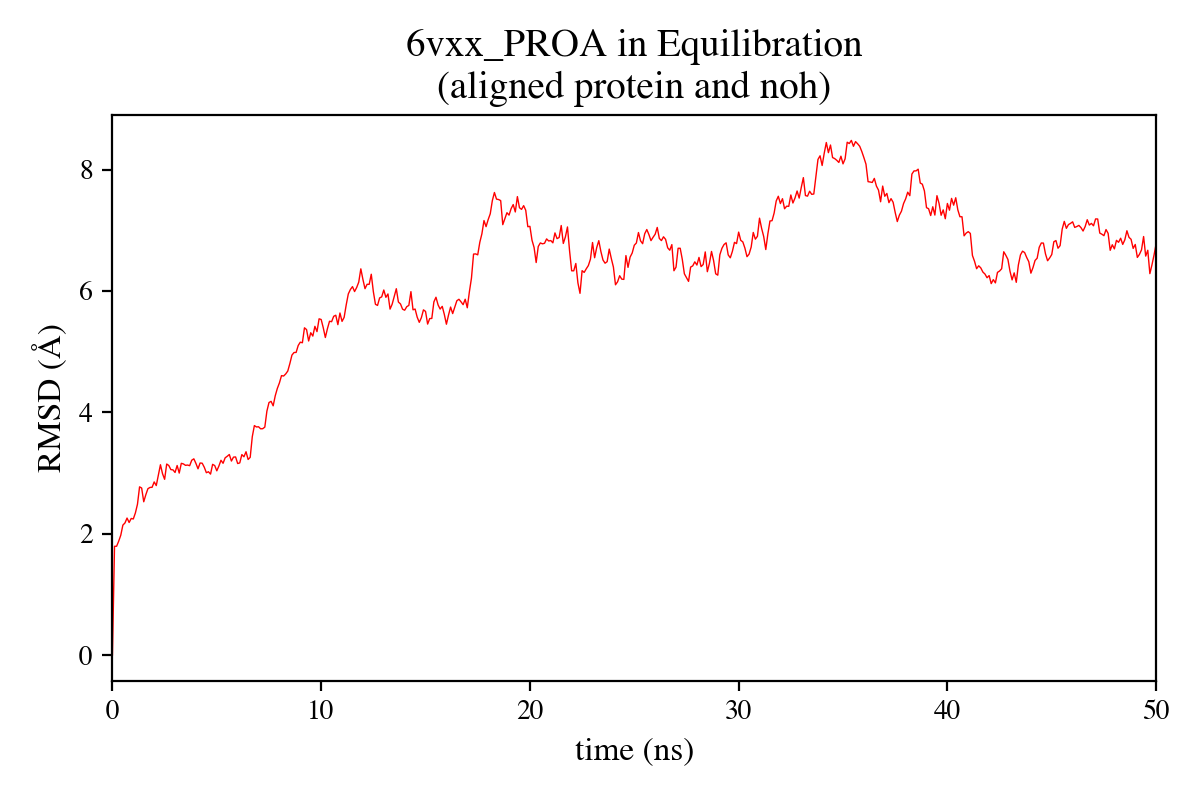

In [21]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
plt.plot(dcdfreq*R_gly_down.rmsd[::spacing, 0], R_gly_down.rmsd[::spacing,-1], linestyle='-', c='r', markersize=0.5, linewidth=0.5)
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel(f"RMSD (Å)", fontsize=12)
plt.xlim(0,50)
plt.title("6vxx_PROA in Equilibration\n(aligned protein and noh)", fontsize=14)
plt.tight_layout()
plt.show()

- RMSD history when aligning backbone of NTD and S2 domain

In [152]:
# 'select' specifies aligned particles
# 'groupselection' list specifies additional RMSDs for listed atoms after 'select' atoms are aligned
# col: nf, time, RMSD
R_gly_down_ordered = analysis.rms.RMSD(U_gly_equildown_dry, U_gly_down_crys, select='backbone and resid 27-304 687-1146')
R_gly_down_ordered.run(step=100)

<IPython.core.display.Javascript object>


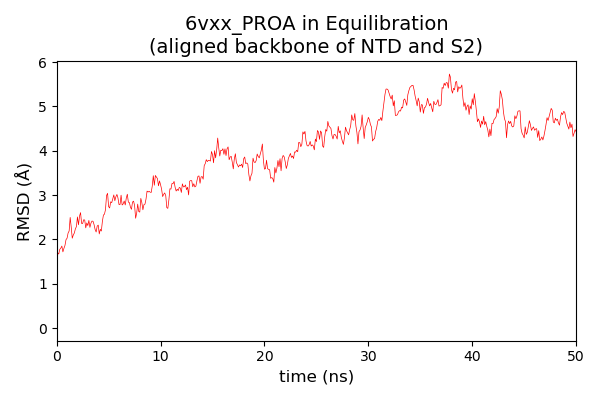

In [153]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
plt.plot(dcdfreq*R_gly_down_ordered.rmsd[::spacing, 0], R_gly_down_ordered.rmsd[::spacing,-1], linestyle='-', c='r', markersize=0.5, linewidth=0.5)
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel(f"RMSD (Å)", fontsize=12)
plt.xlim(0,50)
plt.title("6vxx_PROA in Equilibration\n(aligned backbone of NTD and S2)", fontsize=14)
plt.tight_layout()
plt.show()

## Up equilibrated all-atom system

Last frame

In [67]:
upstruc = '6vsb_UPprotomer'

In [165]:
gly_uppsf = f"{sys_up}/{upstruc}.psf"

In [69]:
gly2_uppdb = f"{equil_gly_up}/minequil_pt1/{upstruc}_eq2-all.pdb"
U_gly2_up = mda.Universe(gly_uppsf, gly2_uppdb)

gly3_uppdb = f"{equil_gly_up}/minequil_pt2/{upstruc}_eq3-all.pdb"
U_gly3_up = mda.Universe(gly_uppsf, gly3_uppdb)

gly4_uppdb = f"{equil_gly_up}/minequil_pt3/{upstruc}_eq4-all.pdb"
U_gly4_up = mda.Universe(gly_uppsf, gly4_uppdb)

gly5_uppdb = f"{equil_gly_up}/minequil_pt4/{upstruc}_eq5-all.pdb"
U_gly5_up = mda.Universe(gly_uppsf, gly5_uppdb)

gly6_uppdb = f"{equil_gly_up}/minequil_pt5/{upstruc}_eq6-all.pdb"
U_gly6_up = mda.Universe(gly_uppsf, gly6_uppdb)

Crystal structure

In [164]:
gly_uppdb_crys = f"{sys_up}/{upstruc}.pdb"

U_gly_up_crys = mda.Universe(gly_uppsf, gly_uppdb_crys)

Equil history

In [71]:
gly_uppsf_dry = f"{sys_up}/{upstruc}-dry.psf"

In [72]:
gly_up_dry2 = f'{equil_gly_up}/minequil_pt1/pt2-dryunwrap.dcd'
gly_up_dry3 = f'{equil_gly_up}/minequil_pt1/pt3-dryunwrap.dcd'
gly_up_dry4 = f'{equil_gly_up}/minequil_pt1/pt4-dryunwrap.dcd'
gly_up_dry5 = f'{equil_gly_up}/minequil_pt1/pt5-dryunwrap.dcd'
gly_up_dry6 = f'{equil_gly_up}/minequil_pt1/pt6-dryunwrap.dcd'
gly_up_dry7 = f'{equil_gly_up}/minequil_pt2/npt1-dryunwrap.dcd'
gly_up_dry8 = f'{equil_gly_up}/minequil_pt2/npt2-dryunwrap.dcd'
gly_up_dry9 = f'{equil_gly_up}/minequil_pt3/pt1-dryunwrap.dcd'
gly_up_dry10 = f'{equil_gly_up}/minequil_pt3/pt2-dryunwrap.dcd'
gly_up_dry11 = f'{equil_gly_up}/minequil_pt4/pt1-dryunwrap.dcd'
gly_up_dry12 = f'{equil_gly_up}/minequil_pt4/pt2-dryunwrap.dcd'
gly_up_dry13 = f'{equil_gly_up}/minequil_pt5/pt1-dryunwrap.dcd'
gly_up_dry14 = f'{equil_gly_up}/minequil_pt5/pt2-dryunwrap.dcd'
gly_up_dry15 = f'{equil_gly_up}/minequil_pt6/pt1-dryunwrap.dcd'
gly_up_dry16 = f'{equil_gly_up}/minequil_pt6/pt2-dryunwrap.dcd'
gly_up_dry17 = f'{equil_gly_up}/minequil_pt6/pt3-dryunwrap.dcd'
gly_up_dry18 = f'{equil_gly_up}/minequil_pt7/pt1-dryunwrap.dcd'
gly_up_dry19 = f'{equil_gly_up}/minequil_pt7/pt2-dryunwrap.dcd'

In [73]:
U_gly_equilup_dry = mda.Universe(gly_uppsf_dry, 
                                   [gly_up_dry2, gly_up_dry3, gly_up_dry4, gly_up_dry5, gly_up_dry6,
                                   gly_up_dry7, gly_up_dry8, gly_up_dry9, gly_up_dry10, gly_up_dry11,
                                   gly_up_dry12, gly_up_dry13, gly_up_dry14, gly_up_dry15, gly_up_dry16,
                                   gly_up_dry17, gly_up_dry18, gly_up_dry19])

RMSD

- RMSD history when aligning protein and non-H atoms

In [143]:
# 'select' specifies aligned particles
# 'groupselection' list specifies additional RMSDs for listed atoms after 'select' atoms are aligned
# col: nf, time, RMSD
R_gly_up = analysis.rms.RMSD(U_gly_equilup_dry, U_gly_up_crys, select='protein and not name H*')
R_gly_up.run(step=100)

In [144]:
np.shape(R_gly_up.rmsd)

(501, 3)

In [145]:
spacing = 1
dcdfreq = 0.001

<IPython.core.display.Javascript object>


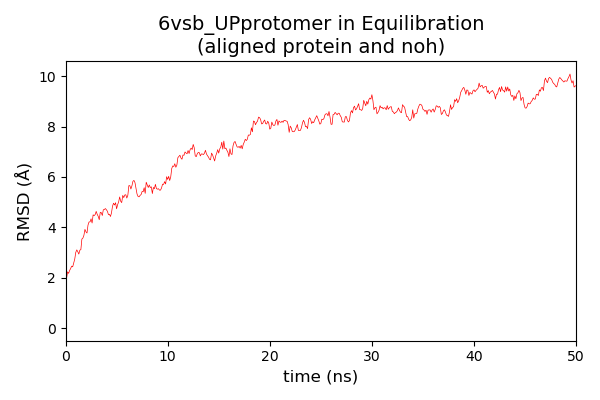

In [146]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
plt.plot(dcdfreq*R_gly_up.rmsd[::spacing, 0], R_gly_up.rmsd[::spacing,-1], linestyle='-', c='r', markersize=0.5, linewidth=0.5)
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel(f"RMSD (Å)", fontsize=12)
plt.xlim(0,50)
plt.title("6vsb_UPprotomer in Equilibration\n(aligned protein and noh)", fontsize=14)
plt.tight_layout()
plt.show()

- RMSD history when aligning backbone of NTD and S2 domain

In [147]:
# 'select' specifies aligned particles
# 'groupselection' list specifies additional RMSDs for listed atoms after 'select' atoms are aligned
# col: nf, time, RMSD
R_gly_up_ordered = analysis.rms.RMSD(U_gly_equilup_dry, U_gly_up_crys, select='backbone and resid 27-304 687-1146')
R_gly_up_ordered.run(step=100)

<IPython.core.display.Javascript object>


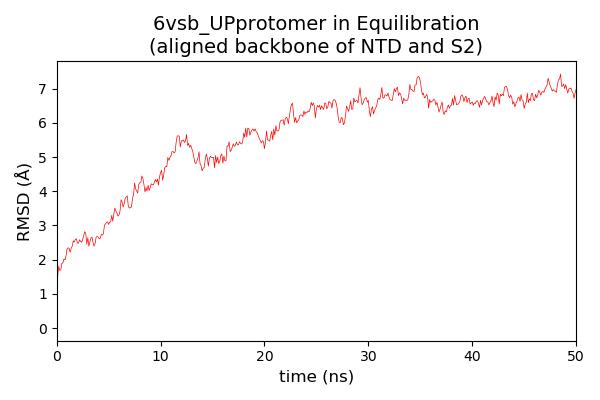

In [148]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)
plt.plot(dcdfreq*R_gly_up_ordered.rmsd[::spacing, 0], R_gly_up_ordered.rmsd[::spacing,-1], linestyle='-', c='r', markersize=0.5, linewidth=0.5)
plt.xlabel("time (ns)", fontsize=12)
plt.ylabel(f"RMSD (Å)", fontsize=12)
plt.xlim(0,50)
plt.title("6vsb_UPprotomer in Equilibration\n(aligned backbone of NTD and S2)", fontsize=14)
plt.tight_layout()
plt.show()

# Analysis

# `PCA`

In [6]:
from MDAnalysis.analysis import align

## Extract coordinates

Down

In [25]:
gly2_down_dry_aligned2downCrys = f'{equil_gly_down}/equildown_dry_aligned2downCrysCA_50ns.dcd'
U_gly_equildown_dry_aligned2downCrys = mda.Universe(gly_downpsf_dry, [gly2_down_dry_aligned2downCrys])

In [330]:
U_gly_equildown_dry_aligned2downCrys

<Universe with 21586 atoms>

In [18]:
len(U_gly_equildown_dry_aligned2downCrys.trajectory)

50016

up

In [18]:
gly2_up_dry_aligned2downCrys = f'{equil_gly_up}/equilup_dry_aligned2downCrysCA_50ns.dcd'
U_gly_equilup_dry_aligned2downCrys = mda.Universe(gly_uppsf_dry, [gly2_up_dry_aligned2downCrys])

In [19]:
len(U_gly_equilup_dry_aligned2downCrys.trajectory)

50012

In [198]:
def getCAxyz(U, satom="protein and name CA"):
    CA = U.select_atoms(satom)
    CAxyz = np.zeros([len(U.trajectory), len(CA), 3])

    i = 0
    for ts in U.trajectory:
        CAxyz[i] = CA.positions
        i += 1
    
    CAxyz = CAxyz.reshape([np.shape(CAxyz)[0], np.shape(CAxyz)[1]*3])
    return CAxyz

In [32]:
CAxyz_o = getCAxyz(U_gly_equilup_dry_aligned2downCrys)
CAxyz_o = CAxyz_o[np.where(R_gly_up.rmsd[:,-1]>0.1)[0]]

In [33]:
CAxyz_c = getCAxyz(U_gly_equildown_dry_aligned2downCrys)
CAxyz_c = CAxyz_c[np.where(R_gly_down.rmsd[:,-1]>0.1)[0]]

In [48]:
# with open('saved_pkl/CAxyz_up_down_50ns_dry_aligned2downCrysCA.pkl', 'wb') as f:
#     pickle.dump([CAxyz_o, CAxyz_c], f)

In [7]:
with open('saved_pkl/CAxyz_up_down_50ns_dry_aligned2downCrysCA.pkl', 'rb') as f:
    CAxyz_o, CAxyz_c = pickle.load(f)

up to down

In [43]:
# k300
k=20000
v=4
struc = '6vsb_UPprotomer'
gly_uppsf_dry = f"{sys_up}/{struc}-dry.psf"
gly_u2ddcd_dry1 = f'{gly3_u2d}/k{k}_{v}ns_pt1/k{k}_{v}ns_pt1-dryunwrap.dcd'

In [44]:
U_gly_u2d_20000 = mda.Universe(gly_uppsf_dry, [gly_u2ddcd_dry1])

In [45]:
# alignment = align.AlignTraj(U_gly_u2d_20000, U_gly_down_crys, 
#                             filename=f'{gly3_u2d}/k{k}_{v}ns_pt1/u2d_dry_aligned2downCrysCA.dcd', select="protein and name CA",)
# alignment.run()

In [75]:
gly2_u2ddcd_dry_aligned2downCrys = f'{gly2_u2d}/k20000_v2_pt1/u2d_dry_aligned2downCrysCA.dcd'
U1_gly2_u2d_aligned2downCrys = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_dry_aligned2downCrys])

gly2_u2ddcd_dry_aligned2downCrys = f'{gly3_u2d}/k20000_4ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
U2_gly2_u2d_aligned2downCrys = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_dry_aligned2downCrys])

gly2_u2ddcd_dry_aligned2downCrys = f'{gly4_u2d}/k20000_4ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
U3_gly2_u2d_aligned2downCrys = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_dry_aligned2downCrys])

gly2_u2ddcd_dry_aligned2downCrys = f'{gly5_u2d}/k20000_4ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
U4_gly2_u2d_aligned2downCrys = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_dry_aligned2downCrys])

gly2_u2ddcd_dry_aligned2downCrys = f'{gly6_u2d}/k20000_4ns_pt1/u2d_dry_aligned2downCrysCA.dcd'
U5_gly2_u2d_aligned2downCrys = mda.Universe(gly_uppsf_dry, [gly2_u2ddcd_dry_aligned2downCrys])

In [32]:
CAxyz_u2d_1 = getCAxyz(U1_gly2_u2d_aligned2downCrys)
CAxyz_u2d_2 = getCAxyz(U2_gly2_u2d_aligned2downCrys)
CAxyz_u2d_3 = getCAxyz(U3_gly2_u2d_aligned2downCrys)
CAxyz_u2d_4 = getCAxyz(U4_gly2_u2d_aligned2downCrys)
CAxyz_u2d_5 = getCAxyz(U5_gly2_u2d_aligned2downCrys)

CAxyz_u2d_repx5 = [CAxyz_u2d_1, CAxyz_u2d_2, CAxyz_u2d_3, CAxyz_u2d_4, CAxyz_u2d_5]

In [104]:
# with open('saved_pkl/CAxyz_u2d_repx5_dry_aligned2downCrysCA.pkl', 'wb') as f:
#     pickle.dump(CAxyz_u2d_repx5, f)

In [8]:
with open('saved_pkl/CAxyz_u2d_repx5_dry_aligned2downCrysCA.pkl', 'rb') as f:
    CAxyz_u2d_1, CAxyz_u2d_2, CAxyz_u2d_3, CAxyz_u2d_4, CAxyz_u2d_5 = pickle.load(f)

down to up

In [ ]:
struc = '6vxx_PROA'
gly_downpsf_dry = f"{sys_down}/{struc}-dry.psf"

In [ ]:
gly_d2udcd_dry1 = f'{gly5_d2u}/k20000_4ns_pt1/k20000_4ns_pt1-dryunwrap.dcd'
gly_d2udcd_dry2 = f'{gly5_d2u}/k20000_4ns_pt2/k20000_4ns_pt2-dryunwrap.dcd'
gly_d2udcd_dry3 = f'{gly5_d2u}/k20000_4ns_pt3/k20000_4ns_pt3-dryunwrap.dcd'

U_gly_d2u_20000 = mda.Universe(gly_uppsf_dry, [gly_d2udcd_dry1, gly_d2udcd_dry2, gly_d2udcd_dry3])

In [79]:
# alignment = align.AlignTraj(U_gly_d2u_20000, U_gly_down_crys, 
#                             filename=f'{gly5_d2u}/k20000_4ns_pt1/d2u_dry_aligned2downCrysCA.dcd', 
#                             select="protein and name CA")
# alignment.run()

In [76]:
gly2_d2udcd_dry_aligned2downCrys = f'{gly2_d2u}/k20000_4ns_pt1/d2u_dry_aligned2downCrysCA.dcd'
U1_gly2_d2u_aligned2downCrys = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_dry_aligned2downCrys])

gly2_d2udcd_dry_aligned2downCrys = f'{gly3_d2u}/k20000_4ns_pt1/d2u_dry_aligned2downCrysCA.dcd'
U2_gly2_d2u_aligned2downCrys = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_dry_aligned2downCrys])

gly2_d2udcd_dry_aligned2downCrys = f'{gly4_d2u}/k20000_4ns_pt1/d2u_dry_aligned2downCrysCA.dcd'
U3_gly2_d2u_aligned2downCrys = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_dry_aligned2downCrys])

gly2_d2udcd_dry_aligned2downCrys = f'{gly5_d2u}/k20000_4ns_pt1/d2u_dry_aligned2downCrysCA.dcd'
U4_gly2_d2u_aligned2downCrys = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_dry_aligned2downCrys])

gly2_d2udcd_dry_aligned2downCrys = f'{gly6_d2u}/k20000_4ns_pt1/d2u_dry_aligned2downCrysCA.dcd'
U5_gly2_d2u_aligned2downCrys = mda.Universe(gly_downpsf_dry, [gly2_d2udcd_dry_aligned2downCrys])

In [94]:
CAxyz_d2u_1 = getCAxyz(U1_gly2_d2u_aligned2downCrys)
CAxyz_d2u_2 = getCAxyz(U2_gly2_d2u_aligned2downCrys)
CAxyz_d2u_3 = getCAxyz(U3_gly2_d2u_aligned2downCrys)
CAxyz_d2u_4 = getCAxyz(U4_gly2_d2u_aligned2downCrys)
CAxyz_d2u_5 = getCAxyz(U5_gly2_d2u_aligned2downCrys)

CAxyz_d2u_repx5 = [CAxyz_d2u_1, CAxyz_d2u_2, CAxyz_d2u_3, CAxyz_d2u_4, CAxyz_d2u_5]

In [102]:
# with open('saved_pkl/CAxyz_d2u_repx5_dry_aligned2downCrysCA.pkl', 'wb') as f:
#     pickle.dump(CAxyz_d2u_repx5, f)

In [9]:
with open('saved_pkl/CAxyz_d2u_repx5_dry_aligned2downCrysCA.pkl', 'rb') as f:
    CAxyz_d2u_1, CAxyz_d2u_2, CAxyz_d2u_3, CAxyz_d2u_4, CAxyz_d2u_5 = pickle.load(f)

### Cartesian XYZ data

In [10]:
total_xyz_data = np.vstack([CAxyz_c[2000:,:],  
                            CAxyz_o[2000:,:]])

In [55]:
np.shape(total_xyz_data)

(96008, 3438)

In [56]:
np.shape(total_xyz_data)

(96008, 3438)

In [57]:
np.shape(CAxyz_u2d_1)

(4000, 3438)

## Perform PCA

Use Cartesian coordinates of 1146 CA atoms (data size: num_of_framex(1146x3))

In [11]:
from sklearn.decomposition import PCA

### All PCs

In [59]:
xyz_pcaAll = PCA()

In [60]:
xyz_pcaAll.fit(total_xyz_data)

PCA()

In [61]:
xyz_pcaAll.explained_variance_ratio_

array([7.05332830e-01, 1.29873451e-01, 3.43321856e-02, ...,
       2.15371442e-16, 9.32206434e-17, 6.24977190e-17])

In [105]:
xyz_pcaAll.explained_variance_ratio_[:15]

array([0.70533283, 0.12987345, 0.03433219, 0.02609036, 0.0163466 ,
       0.01278383, 0.00891356, 0.00644542, 0.00580433, 0.00489093,
       0.00383894, 0.0035072 , 0.00315016, 0.00249435, 0.002197  ])

<IPython.core.display.Javascript object>


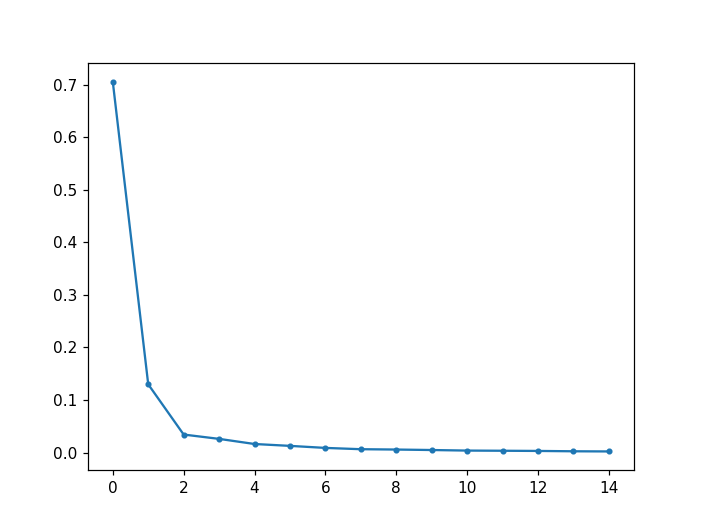

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xyz_pcaAll.explained_variance_ratio_[:15], '.-')

In [62]:
np.sum(xyz_pcaAll.explained_variance_ratio_[:2])

0.8352062810021984

### PC1 and PC2

In [12]:
xyz_pca = PCA(n_components=2)

In [17]:
xyz_pca.fit(total_xyz_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
xyz_pca.explained_variance_ratio_

array([0.70533283, 0.12987345])

In [19]:
np.shape(xyz_pca.components_)

(2, 3438)

In [20]:
xyz_pca.components_

array([[ 0.04855108,  0.00088292, -0.04608206, ..., -0.0212594 ,
         0.07190158, -0.01780618],
       [-0.05487969, -0.07494463,  0.11127672, ..., -0.05584754,
         0.00992545, -0.0030577 ]])

In [21]:
3438//3 #(x1, y1, z1, x2, y2, z2, ..., x1146, y1146, z1146)

1146

In [22]:
np.linalg.norm(xyz_pca.components_[0])

1.0

In [115]:
# with open('saved_pkl/CAxyz_PCvecs_50ns_aligned2downCrysCA.pkl', 'wb') as f:
#     pickle.dump(xyz_pca.components_, f)

In [234]:
with open('saved_pkl/CAxyz_PCvecs_50ns_aligned2downCrysCA.pkl', 'rb') as f:
    PC1, PC2 = pickle.load(f)

Write PC1 and PC2 vector for VMD visualization

In [131]:
# file1 = open('saved_pkl/PCvec1.txt',"a")
# for i in range(1146):
#     file1.write(f'{xyz_pca.components_[0][3*i:3*i+3][0]:.8f}\t{xyz_pca.components_[0][3*i:3*i+3][1]:.8f}\t{xyz_pca.components_[0][3*i:3*i+3][2]:.8f}\n')

# file1.close()

# file1 = open('saved_pkl/PCvec2.txt',"a")
# for i in range(1146):
#     file1.write(f'{xyz_pca.components_[1][3*i:3*i+3][0]:.8f}\t{xyz_pca.components_[1][3*i:3*i+3][1]:.8f}\t{xyz_pca.components_[1][3*i:3*i+3][2]:.8f}\n')

# file1.close()

- PC1

In [258]:
PC1norm = np.linalg.norm(PC1.reshape([1146, 3]),axis=1)**2

In [269]:
np.max(PC1norm)

0.008804841054408322

In [259]:
res_set=np.arange(1146)

<IPython.core.display.Javascript object>


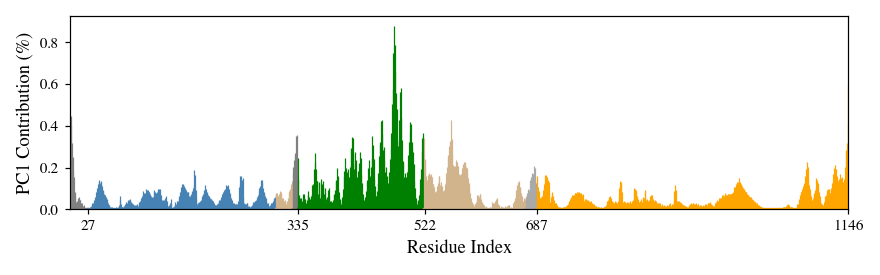

In [335]:
# fig = plt.figure(figsize=[9.5,2.5])
fig = plt.figure(figsize=[8,2.5])
ax = fig.add_subplot(111)

markerline = [0]*12
stemline = [0]*12
baseline = [0]*12

left = [0, 26, 303, 327, 334, 520, 671, 686]
right = [26, 303, 327, 334, 520, 671, 686, 1146]

linec = ['gray', 'steelblue', 'tan', 'gray', 'green', 'tan', 'darkgray', 'orange']
markerc = ['gray', 'steelblue', 'tan', 'gray', 'green', 'tan', 'darkgray', 'orange']
basec = ['gray', 'steelblue', 'tan', 'gray', 'green', 'tan', 'darkgray', 'orange']

for i in range(8):
    markerline[i], stemline[i], baseline[i], = ax.stem(res_set[left[i]:right[i]]+1, PC1norm[left[i]:right[i]]*100,
                                                linefmt=linec[i], markerfmt=None, basefmt=basec[i], 
                                                use_line_collection=True)
    plt.setp(stemline[i], linewidth = 0.8)
    plt.setp(markerline[i], markersize = 0.0, mfc="w")

ax.set_xticks([27, 335, 522, 687, 1146])
ax.set_xticklabels([27, 335, 522, 687, 1146], fontsize=10)
# ax.set_yticklabels(fontsize=11)
    
plt.xlim(0,1146)
plt.ylim(0,)
plt.xlabel('Residue Index', fontsize=12)
plt.ylabel('PC1 Contribution (%)', fontsize=12)
plt.tight_layout()

plt.savefig('ReportPlots/PCplot/PC1contri.png', dpi = 300)

- PC2

In [262]:
PC2norm = np.linalg.norm(PC2.reshape([1146, 3]),axis=1)**2

In [263]:
np.sum(PC2norm)

0.9999999999999989

<IPython.core.display.Javascript object>


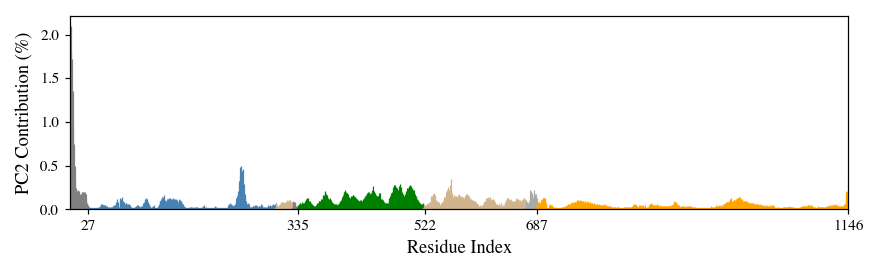

In [330]:
# fig = plt.figure(figsize=[9.5,2.5])
fig = plt.figure(figsize=[8,2.5])
ax = fig.add_subplot(111)

markerline = [0]*12
stemline = [0]*12
baseline = [0]*12

left = [0, 26, 303, 327, 334, 520, 671, 686]
right = [26, 303, 327, 334, 520, 671, 686, 1146]

linec = ['gray', 'steelblue', 'tan', 'gray', 'green', 'tan', 'darkgray', 'orange']
markerc = ['gray', 'steelblue', 'tan', 'gray', 'green', 'tan', 'darkgray', 'orange']
basec = ['gray', 'steelblue', 'tan', 'gray', 'green', 'tan', 'darkgray', 'orange']

for i in range(8):
    markerline[i], stemline[i], baseline[i], = ax.stem(res_set[left[i]:right[i]]+1, PC2norm[left[i]:right[i]]*100,
                                                linefmt=linec[i], markerfmt=None, basefmt=basec[i], 
                                                use_line_collection=True)
    plt.setp(stemline[i], linewidth = 0.8)
    plt.setp(markerline[i], markersize = 0.0, mfc="w")

ax.set_xticks([27, 335, 522, 687, 1146])
ax.set_xticklabels([27, 335, 522, 687, 1146], fontsize=10)
    
plt.xlim(0,1146)
plt.ylim(0,)
plt.xlabel('Residue Index', fontsize=12)
plt.ylabel('PC2 Contribution (%)', fontsize=12)
plt.tight_layout()

plt.savefig('ReportPlots/PCplot/PC2contri.png', dpi = 300)

Project transition trajectories onto PC1-PC2 space

In [23]:
total_xyz_data_pca = xyz_pca.transform(total_xyz_data)

In [24]:
CAxyz_u2d_pca1 = xyz_pca.transform(CAxyz_u2d_1)
CAxyz_u2d_pca2 = xyz_pca.transform(CAxyz_u2d_2)
CAxyz_u2d_pca3 = xyz_pca.transform(CAxyz_u2d_3)
CAxyz_u2d_pca4 = xyz_pca.transform(CAxyz_u2d_4)
CAxyz_u2d_pca5 = xyz_pca.transform(CAxyz_u2d_5)

In [25]:
CAxyz_d2u_pca1 = xyz_pca.transform(CAxyz_d2u_1)
CAxyz_d2u_pca2 = xyz_pca.transform(CAxyz_d2u_2)
CAxyz_d2u_pca3 = xyz_pca.transform(CAxyz_d2u_3)
CAxyz_d2u_pca4 = xyz_pca.transform(CAxyz_d2u_4)
CAxyz_d2u_pca5 = xyz_pca.transform(CAxyz_d2u_5)

In [58]:
np.shape(total_xyz_data_pca)

(96008, 2)

In [59]:
np.shape(CAxyz_o)

(50005, 3438)

In [60]:
np.shape(CAxyz_c)

(50003, 3438)

In [26]:
removefr = 2000

upcolors = np.arange(len(total_xyz_data_pca[(50005-removefr):,1]))/len(total_xyz_data_pca[(50005-removefr):,1])
upcolors = [(ii*0.275, ii*0.51, ii*0.706) for ii in upcolors]

downcolors = np.arange(len(total_xyz_data_pca[:(50005-removefr),1]))/len(total_xyz_data_pca[:(50005-removefr),1])
downcolors = [(ii*255/255, ii*165/255, 0) for ii in downcolors]

In [27]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap(upcolors)
cmap2 = mpl.colors.ListedColormap(downcolors)

<IPython.core.display.Javascript object>


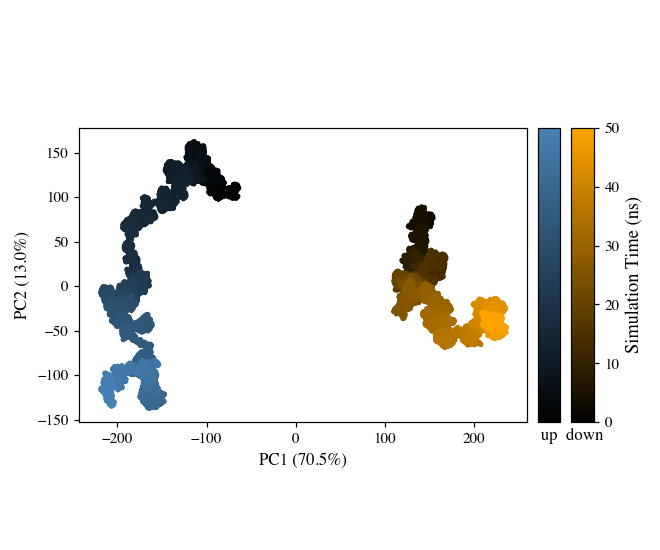

In [28]:
start = 0

fig = plt.figure(figsize=[6,5]) 
ax = fig.add_subplot(111, aspect=1)
sc = ax.scatter(total_xyz_data_pca[:(50005-removefr),0], total_xyz_data_pca[:(50005-removefr),1], s=5, 
           label='down (2-50ns)', c=downcolors)
ax.scatter(total_xyz_data_pca[(50005-removefr):,0], total_xyz_data_pca[(50005-removefr):,1], 
           s=5, label='up (2-50ns)', c=upcolors)
plt.xlabel('PC1 (70.5%)', fontsize=11)
plt.ylabel('PC2 (13.0%)', fontsize=11)

norm = mpl.colors.Normalize(vmin=0, vmax=50)
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.set_yticklabels([], fontsize=10)
cbar.ax.tick_params(size=0)
cbar.set_label('   up  down', labelpad=0, x=0, y=-.02, rotation=0, fontsize=11)

cax2 = divider.append_axes("right", size="5%", pad=0.1)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap2), cax=cax2)
cbar2.ax.set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=10)
cbar2.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/PCplot/PCfreequil.png', dpi = 300)

<IPython.core.display.Javascript object>


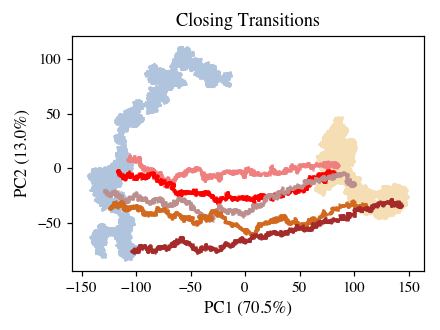

In [228]:
start = 0
removefr = 2000

fig = plt.figure(figsize=[4, 3]) 
ax = fig.add_subplot(111, aspect=1)
ax.scatter(total_xyz_data_pca[:(50005-removefr),0], total_xyz_data_pca[:(50005-removefr),1], s=1, 
           label='down', color='wheat', alpha=0.8)
ax.scatter(total_xyz_data_pca[(50005-removefr):,0], total_xyz_data_pca[(50005-removefr):,1], s=1,
           label='up', color='lightsteelblue', alpha=0.8)

ax.scatter(CAxyz_u2d_pca1[:,0], CAxyz_u2d_pca1[:,1], s=1, 
           label='replicate1', alpha=0.5, color='lightcoral')
ax.scatter(CAxyz_u2d_pca2[:,0], CAxyz_u2d_pca2[:,1], s=1, 
           label='replicate2', alpha=0.5, color='red')
ax.scatter(CAxyz_u2d_pca3[:,0], CAxyz_u2d_pca3[:,1], s=1, 
           label='replicate3', alpha=0.5, color='rosybrown')
ax.scatter(CAxyz_u2d_pca4[:,0], CAxyz_u2d_pca4[:,1], s=1, 
           label='replicate4', alpha=0.5, color='chocolate')
ax.scatter(CAxyz_u2d_pca5[:,0], CAxyz_u2d_pca5[:,1], s=1, 
           label='replicate5', alpha=0.5, color='brown')

plt.xlabel('PC1 (70.5%)', fontsize=11)
plt.ylabel('PC2 (13.0%)', fontsize=11)
plt.title('Closing Transitions', fontsize = 12)
plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/PCplot/PCclosing.png', dpi = 300)

<IPython.core.display.Javascript object>


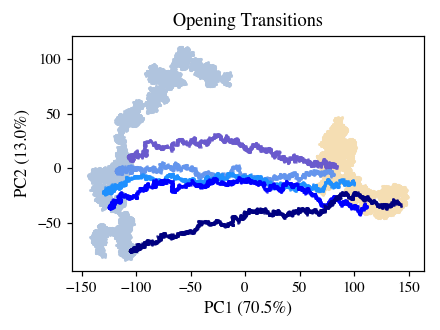

In [229]:
start = 0
removefr = 2000

fig = plt.figure(figsize=[4,3]) 
ax = fig.add_subplot(111, aspect=1)
ax.scatter(total_xyz_data_pca[:(50005-removefr),0], total_xyz_data_pca[:(50005-removefr),1], s=1, 
           label='down', color='wheat', alpha=0.8)
ax.scatter(total_xyz_data_pca[(50005-removefr):,0], total_xyz_data_pca[(50005-removefr):,1], s=1,
           label='up', color='lightsteelblue', alpha=0.8)

ax.scatter(CAxyz_d2u_pca1[:,0], CAxyz_d2u_pca1[:,1], s=1, 
           label='replicate1', alpha=0.5, color='slateblue')
ax.scatter(CAxyz_d2u_pca2[:,0], CAxyz_d2u_pca2[:,1], s=1, 
           label='replicate2', alpha=0.5, color='cornflowerblue')
ax.scatter(CAxyz_d2u_pca3[:,0], CAxyz_d2u_pca3[:,1], s=1, 
           label='replicate3', alpha=0.5, color='dodgerblue')
ax.scatter(CAxyz_d2u_pca4[:,0], CAxyz_d2u_pca4[:,1], s=1, 
           label='replicate4', alpha=0.5, color='blue')
ax.scatter(CAxyz_d2u_pca5[:,0], CAxyz_d2u_pca5[:,1], s=1, 
           label='replicate5', alpha=0.5, color='navy')

plt.xlabel('PC1 (70.5%)', fontsize=11)
plt.ylabel('PC2 (13.0%)', fontsize=11)
plt.title('Opening Transitions', fontsize = 12)
plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/PCplot/PCopening.png', dpi = 300)

<IPython.core.display.Javascript object>


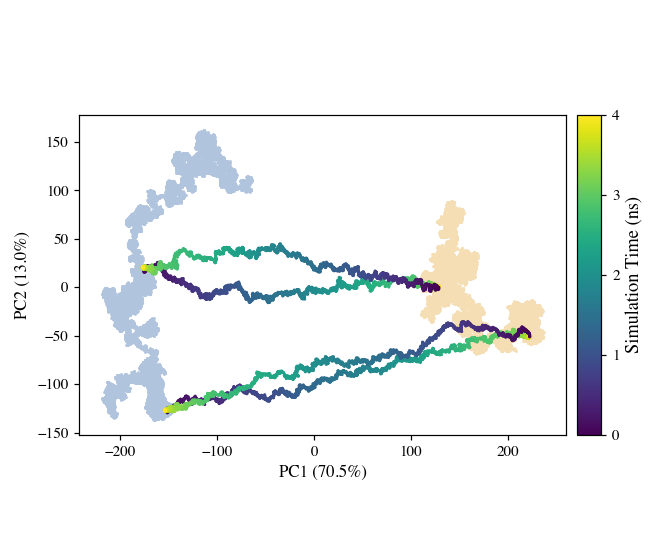

In [34]:
start = 0
removefr = 2000

fig = plt.figure(figsize=[6,5]) 
ax = fig.add_subplot(111, aspect=1)
ax.scatter(total_xyz_data_pca[:(50005-removefr),0], total_xyz_data_pca[:(50005-removefr),1], s=1, 
           label='down (2-50ns)', color='wheat', alpha=0.8)
ax.scatter(total_xyz_data_pca[(50005-removefr):,0], total_xyz_data_pca[(50005-removefr):,1], s=1,
           label='up (2-50ns)', color='lightsteelblue', alpha=0.8)

sc = ax.scatter(CAxyz_u2d_pca1[:,0], CAxyz_u2d_pca1[:,1], s=1, 
           label='closing replicate1', c=range(len(CAxyz_u2d_pca1[:,1])))
# ax.scatter(CAxyz_u2d_pca2[:,0], CAxyz_u2d_pca2[:,1], s=1, 
#            label='closing replicate2', c=range(len(CAxyz_u2d_pca2[:,1])))
# ax.scatter(CAxyz_u2d_pca3[:,0], CAxyz_u2d_pca3[:,1], s=1, 
#            label='closing replicate3', c=range(len(CAxyz_u2d_pca3[:,1])))
# ax.scatter(CAxyz_u2d_pca4[:,0], CAxyz_u2d_pca4[:,1], s=1, 
#            label='closing replicate4', c=range(len(CAxyz_u2d_pca4[:,1])))
ax.scatter(CAxyz_u2d_pca5[:,0], CAxyz_u2d_pca5[:,1], s=1, 
           label='closing replicate5', c=range(len(CAxyz_u2d_pca5[:,1])))

ax.scatter(CAxyz_d2u_pca1[:,0], CAxyz_d2u_pca1[:,1], s=1, 
           label='opening replicate1', c=range(len(CAxyz_d2u_pca1[:,1])))
# ax.scatter(CAxyz_d2u_pca2[:,0], CAxyz_d2u_pca2[:,1], s=1, 
#            label='opening replicate2', c=range(len(CAxyz_d2u_pca2[:,1])))
# ax.scatter(CAxyz_d2u_pca3[:,0], CAxyz_d2u_pca3[:,1], s=1, 
#            label='opening replicate3', c=range(len(CAxyz_d2u_pca3[:,1])))
# ax.scatter(CAxyz_d2u_pca4[:,0], CAxyz_d2u_pca4[:,1], s=1, 
#            label='opening replicate4', c=range(len(CAxyz_d2u_pca4[:,1])))
ax.scatter(CAxyz_d2u_pca5[:,0], CAxyz_d2u_pca5[:,1], s=1, 
           label='opening replicate5', c=range(len(CAxyz_d2u_pca5[:,1])))


plt.xlabel('PC1 (70.5%)', fontsize=11)
plt.ylabel('PC2 (13.0%)', fontsize=11)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = plt.colorbar(sc,cax=cax)
cbar.set_ticks([0, 1000, 2000, 3000, 3999])
cbar.ax.set_yticklabels([0, 1, 2, 3, 4], fontsize=10)

cbar.ax.set_ylabel('Simulation Time (ns)', fontsize = 12, weight="bold")

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/PCplot/PCeolve.png', dpi = 300)

# `Dihedral`

In [35]:
def dihedral_array(U, spacing, start=0):
    dih_atom = U.select_atoms('resid 405 526 622 991 and name CA')
    dih_set = []
    for ts in U.trajectory[start::spacing]:
        ang_test = mda.core.topologyobjects.Dihedral(dih_atom.ix, U, type=None, guessed=False, order=None)
        dih_set.append(ang_test.value())
    dih_set = np.array(dih_set)
    return dih_set

In [207]:
dih_up_gly = dihedral_array(U_gly_equilup_dry, spacing=10, start=0)

c:\users\xinyan\anaconda3\envs\anaconda37pc\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


In [209]:
dih_down_gly = dihedral_array(U_gly_equildown_dry, spacing=10, start=0)

In [210]:
# with open('saved_pkl/pseudodih_up_down_gly_50ns.pkl', 'wb') as f:
#     pickle.dump([dih_up_gly, dih_down_gly], f)

In [36]:
with open('saved_pkl/pseudodih_up_down_gly_50ns.pkl', 'rb') as f:
    dih_up_gly, dih_down_gly = pickle.load(f)

In [230]:
np.mean(dih_down_gly[st:])

17.860467570932148

In [231]:
np.mean(dih_up_gly[st:])

80.54346298896887

<IPython.core.display.Javascript object>


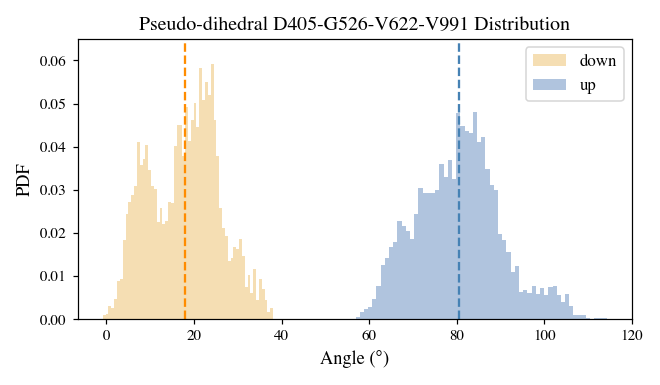

In [233]:
st = 200
fig = plt.figure(figsize=[6,3.5])
ax = fig.add_subplot(111)
plt.hist(dih_down_gly[st:], bins=60, alpha=1, density=True, label='down', color='wheat')
plt.hist(dih_up_gly[st:], bins=60, alpha=1, density=True, label='up', color='lightsteelblue')

plt.vlines(np.mean(dih_down_gly[st:]), 0, 0.07, colors='darkorange', linestyle='--')
plt.vlines(np.mean(dih_up_gly[st:]), 0, 0.07, colors='steelblue', linestyle='--')

# plt.xlim(45, 80)
plt.ylim(0,0.065)
plt.xlabel('Angle (\N{DEGREE SIGN})', fontsize=12)
plt.ylabel('PDF', fontsize=12)
plt.title(f"Pseudo-dihedral D405-G526-V622-V991 Distribution", fontsize=13)
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/GlobalPlot/dih_distribution.png', dpi = 300)

In [77]:
U_gly_d2u_repx5 = [U1_gly2_d2u_aligned2downCrys, U2_gly2_d2u_aligned2downCrys, U3_gly2_d2u_aligned2downCrys, 
                   U4_gly2_d2u_aligned2downCrys, U5_gly2_d2u_aligned2downCrys]

U_gly_u2d_repx5 = [U1_gly2_u2d_aligned2downCrys, U2_gly2_u2d_aligned2downCrys, U3_gly2_u2d_aligned2downCrys, 
                   U4_gly2_u2d_aligned2downCrys, U5_gly2_u2d_aligned2downCrys]

In [266]:
dih_gly_d2u_repx5 = []
for universe in U_gly_d2u_repx5:
    dih_gly_d2u_repx5.append(dihedral_array(universe, spacing=10, start=0))

c:\users\xinyan\anaconda3\envs\anaconda37pc\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


In [272]:
dih_gly_u2d_repx5 = []
for universe in U_gly_u2d_repx5:
    dih_gly_u2d_repx5.append(dihedral_array(universe, spacing=10, start=0))

c:\users\xinyan\anaconda3\envs\anaconda37pc\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


In [273]:
# with open('saved_pkl/pseudodih_d2u_u2d_gly_repx5.pkl', 'wb') as f:
#     pickle.dump([dih_gly_d2u_repx5, dih_gly_u2d_repx5], f)

In [38]:
with open('saved_pkl/pseudodih_d2u_u2d_gly_repx5.pkl', 'rb') as f:
    dih_gly_d2u_repx5, dih_gly_u2d_repx5 = pickle.load(f)

In [39]:
d2u_color = ['slateblue', 'cornflowerblue', 'dodgerblue', 'blue', 'navy']
u2d_color = ['lightcoral', 'red', 'rosybrown', 'chocolate', 'brown']

<IPython.core.display.Javascript object>


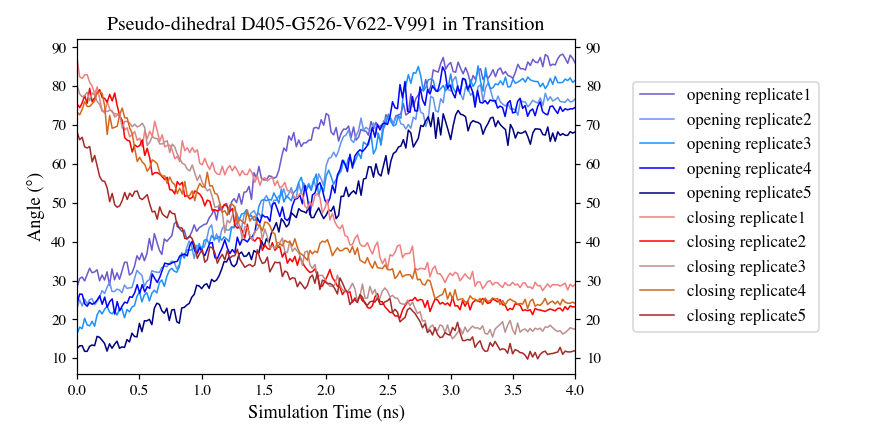

In [40]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(111)
spacing = 2

for i in range(5):
    plt.plot(np.linspace(0,4,len(dih_gly_d2u_repx5[i][::spacing])), dih_gly_d2u_repx5[i][::spacing], 
             linestyle='-', c=d2u_color[i], markersize=0.5, linewidth=1.0, label=f'opening replicate{i+1}')
    
for i in range(5):
    plt.plot(np.linspace(0,4,len(dih_gly_u2d_repx5[i][::spacing])), dih_gly_u2d_repx5[i][::spacing], 
             linestyle='-', c=u2d_color[i], markersize=0.5, linewidth=1.0, label=f'closing replicate{i+1}')


plt.title(f"Pseudo-dihedral D405-G526-V622-V991 in Transition", fontsize=13)
plt.xlabel("Simulation Time (ns)", fontsize=12)
plt.ylabel(f"Angle (\N{DEGREE SIGN})", fontsize=12)
plt.xlim(0, 4)

box = ax.get_position()
ax.set_position([box.x0*0.9, box.y0, box.width * 1.05, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5., fontsize=11)

ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True,
               bottom=True, top=False, left=True, right=True)

plt.tight_layout()
plt.show()

plt.savefig('ReportPLots/GlobalPlot/dih_history.png', dpi = 300)

# `RMSD`

In [78]:
U_gly_down_target = [U_gly2_down, U_gly3_down, U_gly4_down, U_gly5_down, U_gly6_down]
U_gly_up_target = [U_gly2_up, U_gly3_up, U_gly4_up, U_gly5_up, U_gly6_up]

In [79]:
U_gly2_down.select_atoms("backbone and not name H*")

<AtomGroup with 4583 atoms>

In [80]:
U_gly2_down.select_atoms("protein and not name H*")

<AtomGroup with 8943 atoms>

In [81]:
rmsd_gly_u2d_repx5 = []
for i in range(5):
    Rthis = analysis.rms.RMSD(U_gly_u2d_repx5[i], U_gly_down_target[i], select='protein and not name H*')
    Rthis.run(step=10)
    rmsd_gly_u2d_repx5.append(Rthis.rmsd)

rmsd_gly_d2u_repx5 = []
for i in range(5):
    Rthis = analysis.rms.RMSD(U_gly_d2u_repx5[i], U_gly_up_target[i], select='protein and not name H*')
    Rthis.run(step=10)
    rmsd_gly_d2u_repx5.append(Rthis.rmsd)

In [82]:
# with open('saved_pkl/rmsd2target_d2u_u2d_gly_repx5_heavyatoms.pkl', 'wb') as f:
#     pickle.dump([rmsd_gly_d2u_repx5, rmsd_gly_u2d_repx5], f)

In [85]:
with open('saved_pkl/rmsd2target_d2u_u2d_gly_repx5_heavyatoms.pkl', 'rb') as f:
    rmsd_gly_d2u_repx5, rmsd_gly_u2d_repx5 = pickle.load(f)

protein heavy atoms

<IPython.core.display.Javascript object>


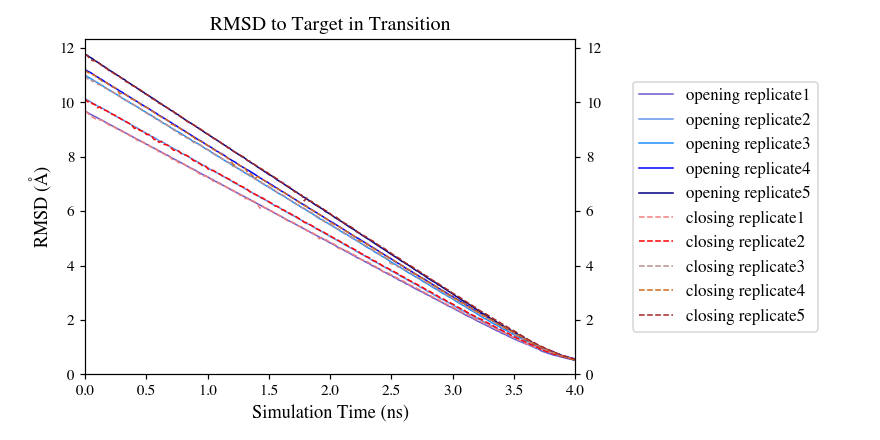

In [92]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(111)
spacing = 2

for i in range(5):
    plt.plot(np.linspace(0,4,len(rmsd_gly_d2u_repx5[i][::spacing,-1])), rmsd_gly_d2u_repx5[i][::spacing,-1], 
             linestyle='-', c=d2u_color[i], markersize=0.5, linewidth=1.0, label=f'opening replicate{i+1}')
    
    
for i in range(5):
    plt.plot(np.linspace(0,4,len(rmsd_gly_u2d_repx5[i][::spacing,-1])), rmsd_gly_u2d_repx5[i][::spacing,-1], 
             linestyle='--', c=u2d_color[i], markersize=0.5, linewidth=1.0, label=f'closing replicate{i+1}')


plt.title(f"RMSD to Target in Transition", fontsize=13)
plt.xlabel("Simulation Time (ns)", fontsize=12)
plt.ylabel("RMSD ($\mathrm{\AA}$)", fontsize=12)
plt.xlim(0, 4)
plt.ylim(0,)

# plt.plot()

box = ax.get_position()
ax.set_position([box.x0*0.9, box.y0, box.width * 1.05, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5., fontsize=11)

ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True,
               bottom=True, top=False, left=True, right=True)

plt.tight_layout()
plt.show()

plt.savefig('ReportPlots/GlobalPlot/rmsd2target.png', dpi = 300)